In [229]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.ensemble import RandomForestRegressor

In [195]:
def plot_timestamp_vs_duration(dataframe):
    data_copy = dataframe.copy()
    data_copy['Eyetracker timestamp'] = pd.to_datetime(data_copy['Eyetracker timestamp'], unit='ms')
    data_copy['Recording duration'] = pd.to_datetime(data_copy['Recording duration'], unit='ms')
    plt.figure(figsize=(10, 6))
    plt.scatter(data_copy['Eyetracker timestamp'], data_copy['Recording duration'])
    plt.xlabel('Eyetracker Timestamp')
    plt.ylabel('Recording Duration')
    plt.title('Eyetracker Timestamp vs Recording Duration')

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gcf().autofmt_xdate()
    
def load_questionnaire_data(file_path):
    return pd.read_csv(file_path, encoding='ISO-8859-1')

def interpolate_columns(df, columns):
    for col in columns:
        df[col] = df[col].interpolate(method='cubic')
    df.fillna(method='backfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

def convert_object_columns_to_numeric(df, obj_cols):
    for col in obj_cols:
        try:
            df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
        except ValueError:
            pass
    return df

def drop_duplicates(df, columns_to_check):
    df.drop_duplicates(subset=columns_to_check, keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def process_csv_file(filepath, questionnaire_df, filename):
    df = pd.read_csv(filepath)
#     df.drop('Participant name', axis=1, inplace=True)
    trial = int(os.path.basename(filepath).split('_trial_')[1].split('.')[0])
    participant = re.search(r"participant_(\d+)_trial", os.path.basename(filepath)).group(1)
    
    df['Trial'] = trial
#     df['Participant name'] = 'Participant' + participant
    
    df['Participant name'] = df['Participant name'].str[-2:].astype(int)
    df = df.rename({'Participant name': 'Participant nr'},axis = 1)
    try:
        df = pd.merge(df, questionnaire_df[['Participant nr','Total Score extended']], on='Participant nr', how='left')
    except KeyError:
        pass
    
    columns_to_interpolate = ['Gaze point X', 'Gaze point Y', 'Gaze point left X', 'Gaze point left Y', 
                              'Gaze point right X', 'Gaze point right Y', 'Gaze direction left X', 
                              'Gaze direction left Y', 'Gaze direction left Z', 'Gaze direction right X', 
                              'Gaze direction right Y', 'Gaze direction right Z']
    
    df = interpolate_columns(df, columns_to_interpolate)
    
    obj_cols = df.select_dtypes(include=['object']).columns
    df = convert_object_columns_to_numeric(df, obj_cols)
    
    columns_to_check_duplicates = ['Participant nr', 'Eye movement type', 'Recording duration', 'Gaze event duration', 'Pupil diameter left', 'Pupil diameter right']
    df = drop_duplicates(df, columns_to_check_duplicates)
    
    df.drop(columns=['Unnamed: 0'], inplace=True)
    
    return df

def load_and_process_data(directory, questionnaire_df):
    dataframes = []
    
    for filename in os.listdir(directory):
        if "dataset_II_" in filename and filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            print("Loading:", filepath)
            df = process_csv_file(filepath, questionnaire_df,filename)
            dataframes.append(df)
    
    all_data = pd.concat(dataframes, ignore_index=True)
    print("Shape of the loaded and processed data:", all_data.shape)
    return all_data

questionnaire_file_path = 'D:/Essex/Data Science/Assignment/EyeT/Questionnaire_datasetIA.csv'
data_directory = 'D:/Essex/Data Science/Assignment/EyeT/EyeT/'

questionnaire_df = load_questionnaire_data(questionnaire_file_path)
all_data = load_and_process_data(data_directory, questionnaire_df)
df = all_data.copy()

Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_10_trial_0.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_10_trial_1.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_10_trial_2.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_10_trial_3.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_14_trial_1.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_14_trial_3.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_18_trial_0.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_18_trial_1.csv
Loading: D:/Essex/Data S

Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_6_trial_8.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_6_trial_9.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_8_trial_0.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_8_trial_1.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_8_trial_10.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_8_trial_11.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_8_trial_12.csv
Loading: D:/Essex/Data Science/Assignment/EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_8_trial_13.csv
Loading: D:/Essex/Data Scien

In [196]:
def group_func(group):
    return group.mode().iloc[0]

In [197]:
df

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant nr,Recording name,Recording date,Recording date UTC,Recording start time,...,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y,Trial,Total Score extended
0,4394847,2575955327,Eye Tracker,Participant10,29.10.2020,10,Recording1,29.10.2020,29.10.2020,14:02:15.450,...,8.0,5.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,117
1,4400762,2575961242,Eye Tracker,Participant10,29.10.2020,10,Recording1,29.10.2020,29.10.2020,14:02:15.450,...,25.0,16.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,117
2,4425765,2575986245,Eye Tracker,Participant10,29.10.2020,10,Recording1,29.10.2020,29.10.2020,14:02:15.450,...,8.0,6.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,117
3,4434123,2575994603,Eye Tracker,Participant10,29.10.2020,10,Recording1,29.10.2020,29.10.2020,14:02:15.450,...,17.0,17.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,117
4,4450780,2576011260,Eye Tracker,Participant10,29.10.2020,10,Recording1,29.10.2020,29.10.2020,14:02:15.450,...,233.0,13.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314852,65023111,532210569464,Eye Tracker,Participant0038,16.03.2021,38,Recording4,16.03.2021,16.03.2021,14:16:08.297,...,42.0,809.0,947.0,533.0,0.4897,0.4935,-389.0,326.0,3,94
314853,65031263,532210577616,Eye Tracker,Participant0038,16.03.2021,38,Recording4,16.03.2021,16.03.2021,14:16:08.297,...,98.0,695.0,947.0,533.0,0.4897,0.4935,-389.0,326.0,3,94
314854,65128503,532210674856,Eye Tracker,Participant0038,16.03.2021,38,Recording4,16.03.2021,16.03.2021,14:16:08.297,...,33.0,329.0,947.0,533.0,0.4897,0.4935,-389.0,326.0,3,94
314855,65153207,532210699560,Eye Tracker,Participant0038,16.03.2021,38,Recording4,16.03.2021,16.03.2021,14:16:08.297,...,33.0,329.0,947.0,533.0,0.4897,0.4935,-389.0,326.0,3,94


In [198]:
df.columns

Index(['Recording timestamp', 'Computer timestamp', 'Sensor', 'Project name',
       'Export date', 'Participant nr', 'Recording name', 'Recording date',
       'Recording date UTC', 'Recording start time',
       'Recording start time UTC', 'Recording duration', 'Timeline name',
       'Recording Fixation filter name', 'Recording software version',
       'Recording resolution height', 'Recording resolution width',
       'Recording monitor latency', 'Eyetracker timestamp', 'Event',
       'Event value', 'Gaze point X', 'Gaze point Y', 'Gaze point left X',
       'Gaze point left Y', 'Gaze point right X', 'Gaze point right Y',
       'Gaze direction left X', 'Gaze direction left Y',
       'Gaze direction left Z', 'Gaze direction right X',
       'Gaze direction right Y', 'Gaze direction right Z',
       'Pupil diameter left', 'Pupil diameter right', 'Validity left',
       'Validity right', 'Eye position left X (DACSmm)',
       'Eye position left Y (DACSmm)', 'Eye position left Z (D

# Creating Histograms

array([[<AxesSubplot: title={'center': 'Recording timestamp'}>,
        <AxesSubplot: title={'center': 'Computer timestamp'}>,
        <AxesSubplot: title={'center': 'Participant nr'}>,
        <AxesSubplot: title={'center': 'Recording duration'}>,
        <AxesSubplot: title={'center': 'Recording resolution height'}>,
        <AxesSubplot: title={'center': 'Recording resolution width'}>,
        <AxesSubplot: title={'center': 'Recording monitor latency'}>],
       [<AxesSubplot: title={'center': 'Eyetracker timestamp'}>,
        <AxesSubplot: title={'center': 'Gaze point X'}>,
        <AxesSubplot: title={'center': 'Gaze point Y'}>,
        <AxesSubplot: title={'center': 'Gaze point left X'}>,
        <AxesSubplot: title={'center': 'Gaze point left Y'}>,
        <AxesSubplot: title={'center': 'Gaze point right X'}>,
        <AxesSubplot: title={'center': 'Gaze point right Y'}>],
       [<AxesSubplot: title={'center': 'Gaze direction left X'}>,
        <AxesSubplot: title={'center': 'G

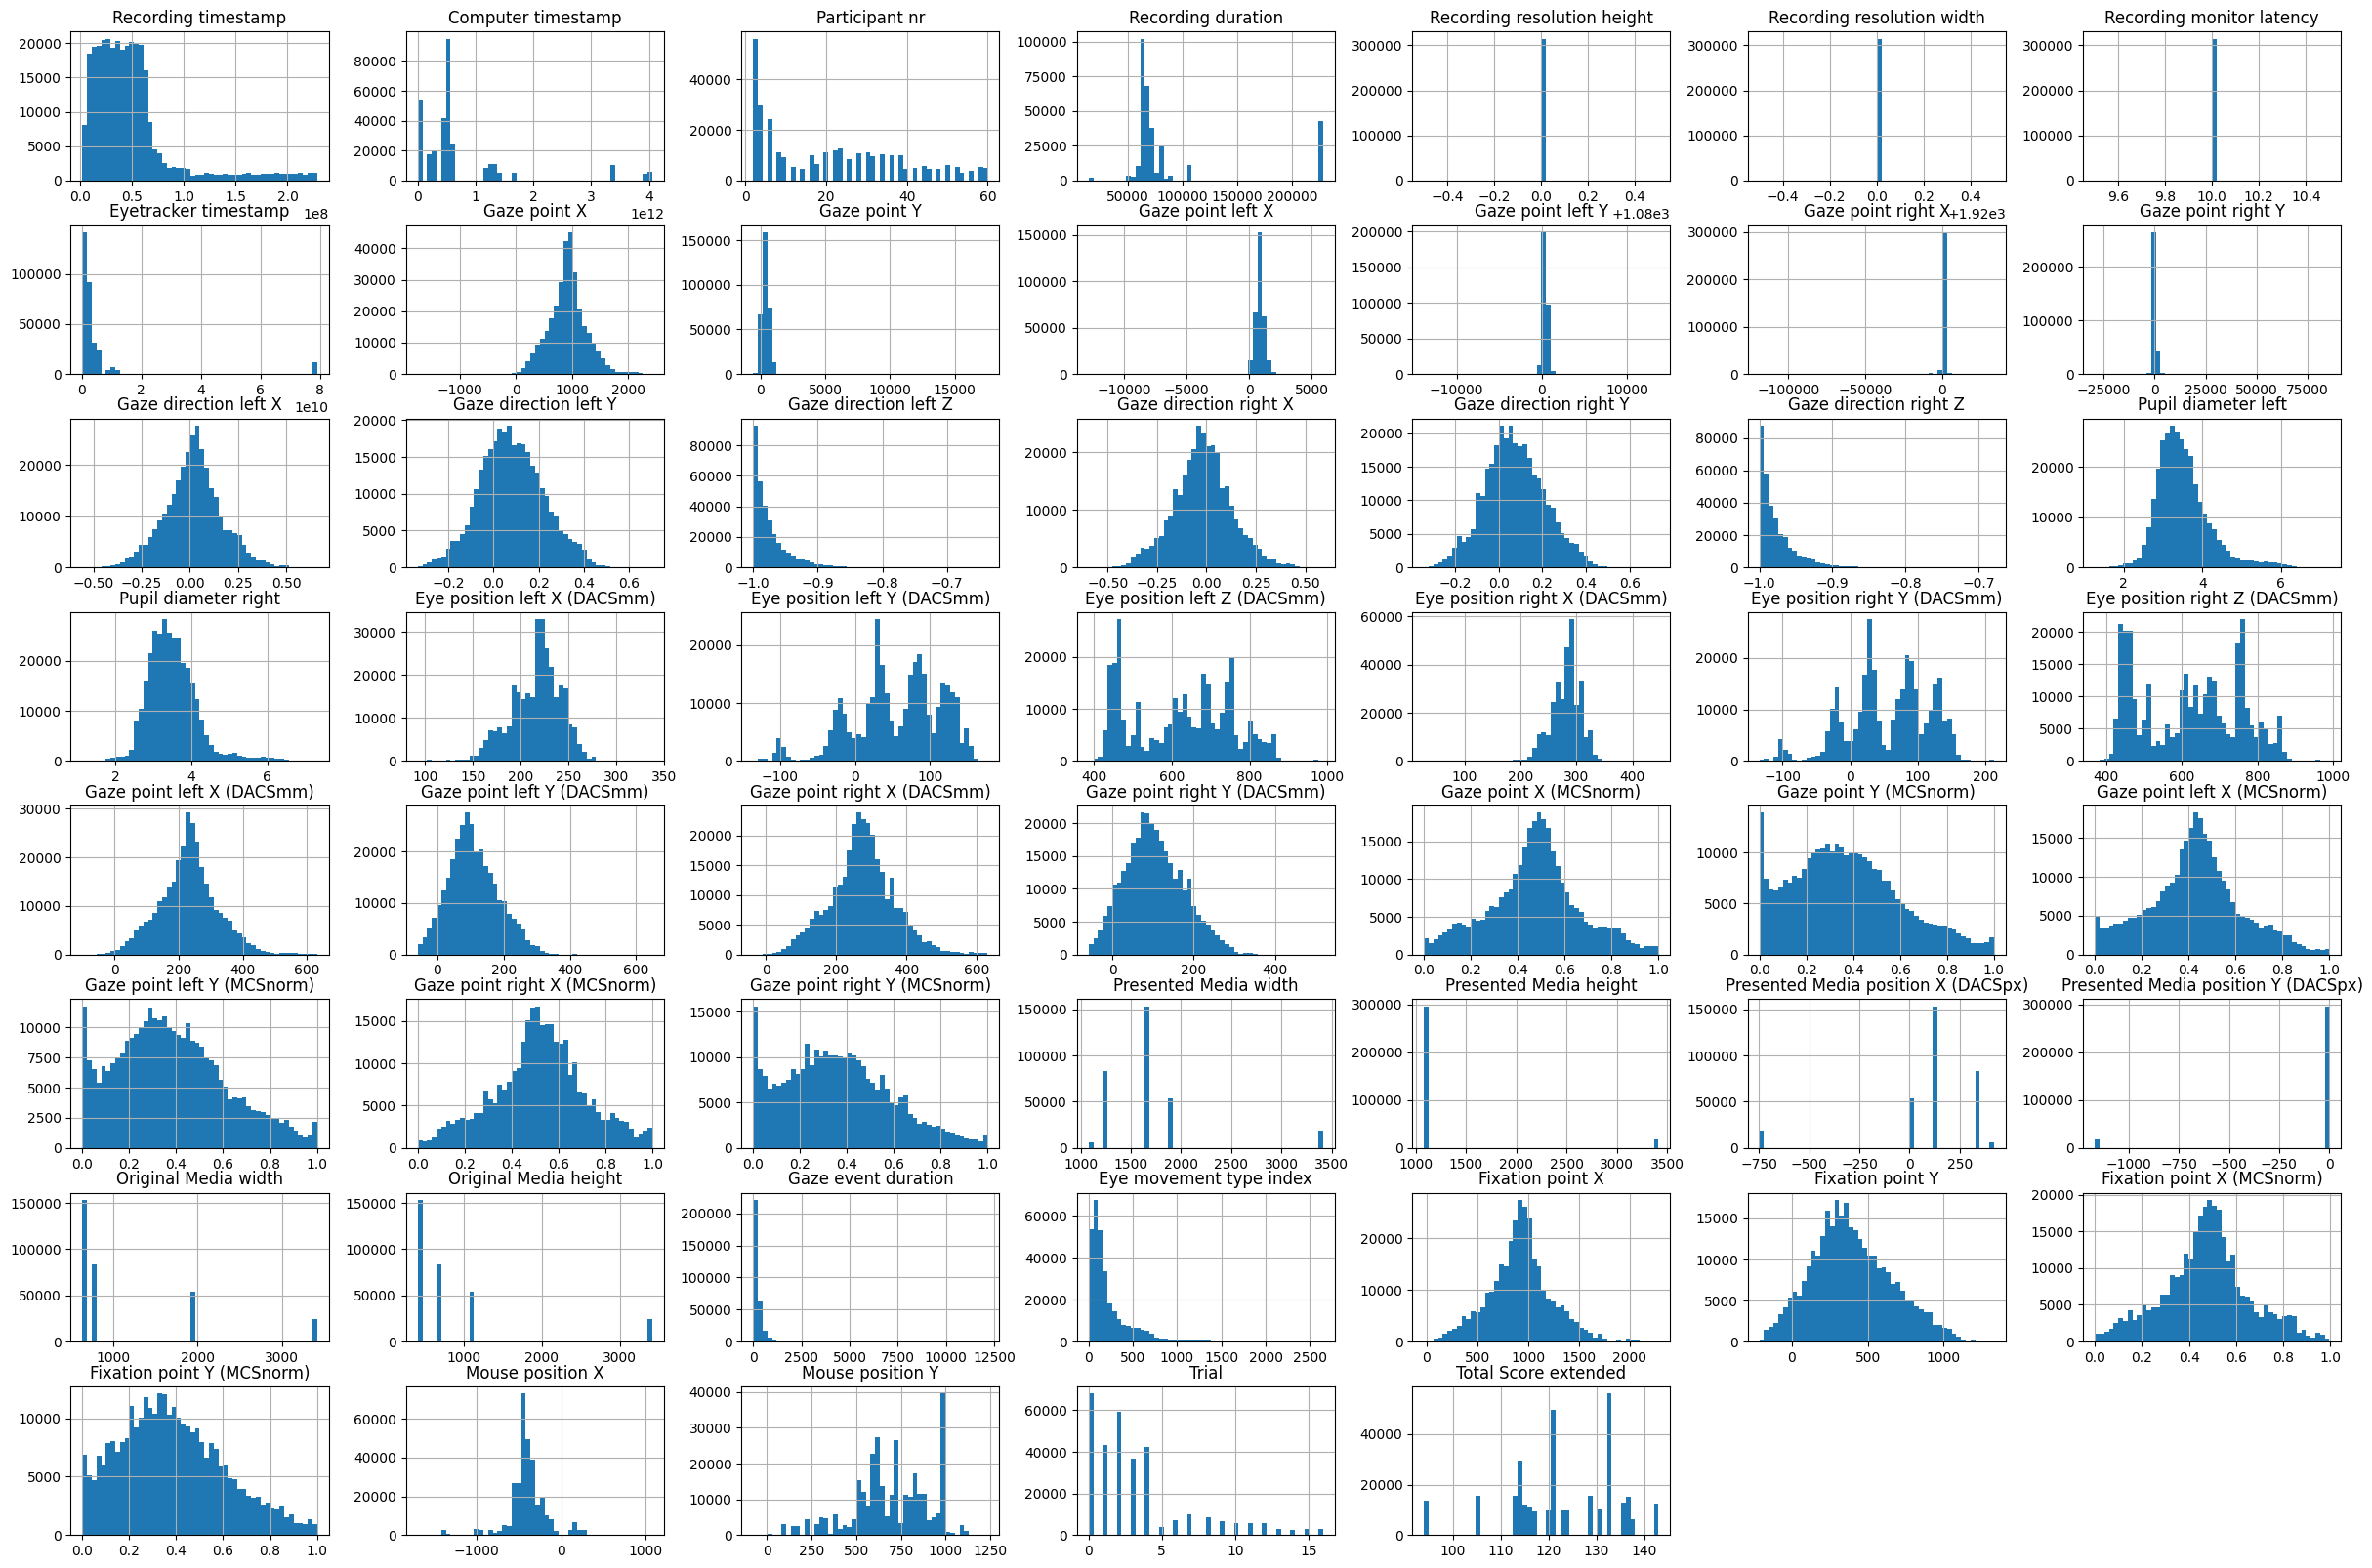

In [199]:
df.hist(bins=50, figsize=(30,20))

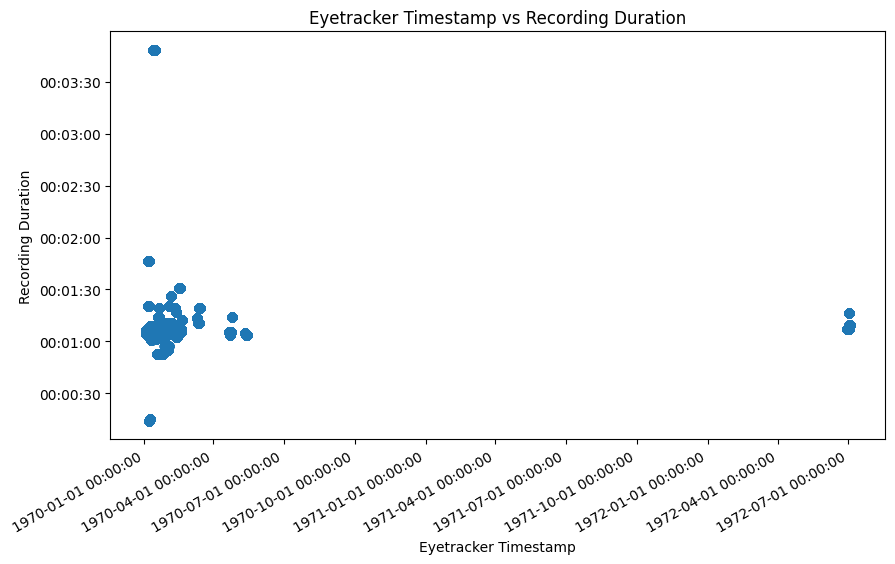

In [200]:
plot_timestamp_vs_duration(df)

In [201]:
mappedData = df.groupby('Participant nr').agg({'Recording duration': 'sum'})
first_index = lambda x: x.iloc[0]
mappedData['Gaze event duration'] = df.groupby('Participant nr').agg({'Gaze event duration': 'sum'})
mappedData['Total Score Extended'] = df.groupby('Participant nr')['Total Score extended'].agg(first_index)
mappedData = mappedData.reset_index()
mappedData = mappedData.drop_duplicates(subset='Participant nr', keep='first')
mappedData = mappedData.sort_values(by='Total Score Extended', ascending=False)
mappedData = mappedData.reset_index(drop=True)
mappedData

,Participant nr,Recording duration,Gaze event duration,Total Score Extended
0,24,950433878,1415793.0,143
1,18,434794781,2580281.0,138
2,46,267558051,1797305.0,137
3,28,691370832,2114990.0,137
4,54,188524954,753261.0,136
5,36,651073391,1662080.0,136
6,2,10948287436,7003804.0,133
7,58,346564097,2135532.0,131
8,40,262295069,1594512.0,131
9,30,788635878,3341229.0,129


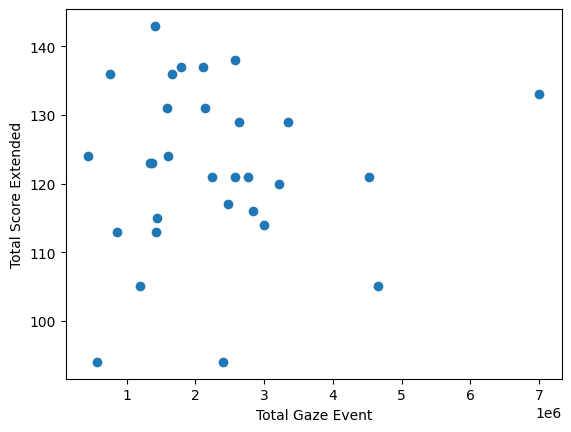

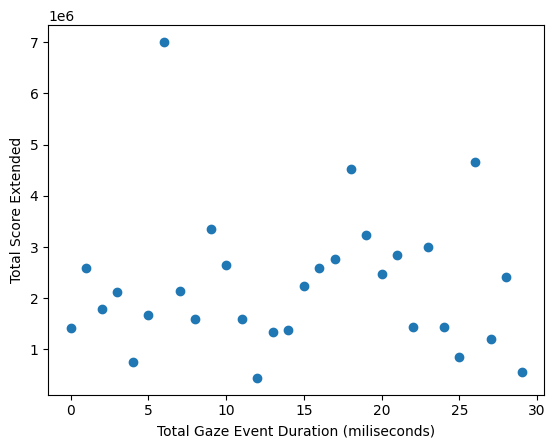

In [202]:
# Plot 'Recording duration' vs 'Total Score Extended'
plt.scatter(mappedData['Gaze event duration'], mappedData['Total Score Extended'])
plt.xlabel('Total Gaze Event')
plt.ylabel('Total Score Extended')
plt.show()
plt.scatter(mappedData.index,mappedData['Gaze event duration'])
plt.xlabel('Total Gaze Event Duration (miliseconds)')
plt.ylabel('Total Score Extended')
plt.show()

In [203]:
#Find sum of null values
print("nulls:",df.isnull().sum())

nulls: Recording timestamp              0
Computer timestamp               0
Sensor                           0
Project name                     0
Export date                      0
                              ... 
Fixation point Y (MCSnorm)       0
Mouse position X              2643
Mouse position Y              2643
Trial                            0
Total Score extended             0
Length: 72, dtype: int64


In [204]:
#One-Hot Encoding for Further Preprocessing
encoding = pd.get_dummies(df['Eye movement type'])
df = pd.concat([df, encoding], axis=1)
df.drop('Eye movement type', axis=1, inplace=True)
data_after_encoding = df

# Finding Correlation

In [205]:
# Compute correlation matrix
matrix = df.corr()

# Extract correlation coefficients for the score column
score = matrix['Total Score extended']
print(score)

C:\Users\Ashir\AppData\Local\Temp\ipykernel_4348\2725473875.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = df.corr()


Recording timestamp                    0.277578
Computer timestamp                     0.114024
Participant nr                        -0.176348
Recording duration                     0.360401
Recording resolution height                 NaN
Recording resolution width                  NaN
Recording monitor latency                   NaN
Eyetracker timestamp                   0.074487
Gaze point X                          -0.016286
Gaze point Y                          -0.105454
Gaze point left X                     -0.004272
Gaze point left Y                     -0.068372
Gaze point right X                    -0.016793
Gaze point right Y                     0.048817
Gaze direction left X                  0.033442
Gaze direction left Y                  0.022850
Gaze direction left Z                 -0.082381
Gaze direction right X                 0.042559
Gaze direction right Y                 0.012836
Gaze direction right Z                -0.114506
Pupil diameter left                    0

In [206]:
#We are fetching all numric columns to make our correlation more precise
nrmilize_cols = df.select_dtypes(include=['float64', 'int64','uint8']).columns.tolist()
num_cols = df[nrmilize_cols].copy()
num_cols = num_cols.fillna(0)

In [207]:
#Now normaailzing the data for that we are using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
minMax = MinMaxScaler()
minMax_scalled = minMax.fit_transform(num_cols)
minMax_normalized = pd.DataFrame(minMax_scalled, columns=num_cols.columns)

In [208]:
minMax_Y = minMax_normalized['Total Score extended']
minMax_X = minMax_normalized.drop(['Total Score extended'], axis=1)

In [209]:
#Extracting Important Features using DecisionTreeRegressor 
from sklearn.tree import DecisionTreeRegressor
decisionTree = DecisionTreeRegressor()
decisionTree.fit(minMax_X, minMax_Y)
features_imp = decisionTree.feature_importances_
features_imp

array([ 2.71150912e-14,  2.07431991e-01,  2.63898268e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.08325182e-01,  3.55419965e-15,
        2.33226201e-13,  1.11700427e-12,  1.20453537e-13,  1.39037365e-13,
        6.16620247e-16,  3.81201890e-15,  7.26152051e-14,  2.36915021e-13,
        2.21160417e-15,  3.76202176e-13,  1.52403769e-13,  1.93104754e-04,
        5.54971730e-15,  4.27483899e-03,  4.80528241e-03,  5.67734911e-03,
        1.13984277e-04,  1.50903958e-01,  1.37345062e-01,  6.74823790e-06,
        5.01700097e-14,  4.22750566e-15,  1.37598915e-15,  3.36268030e-13,
        7.38980938e-13,  6.38571314e-17, -2.89834073e-16,  1.24935842e-13,
        1.11795866e-14,  0.00000000e+00, -2.60392253e-19,  7.71206540e-04,
        2.30699893e-03,  1.64539428e-04,  3.95796225e-18, -9.66445847e-17,
        4.06277013e-17,  7.01203788e-17,  6.08487058e-16,  2.85745976e-13,
        1.39713463e-16,  1.36014575e-02,  2.72629906e-05,  1.52766145e-04,
        0.00000000e+00,  

In [210]:
import numpy as np
features_imp = decisionTree.feature_importances_
features_imp = np.round(features_imp * 100, decimals=2)
features_dict = {attr: imp for attr, imp in zip(minMax_X.columns, features_imp)}
features_dict

{'Recording timestamp': 0.0,
 'Computer timestamp': 20.74,
 'Recording duration': 26.39,
 'Recording resolution height': 0.0,
 'Recording resolution width': 0.0,
 'Recording monitor latency': 0.0,
 'Eyetracker timestamp': 20.83,
 'Gaze point X': 0.0,
 'Gaze point Y': 0.0,
 'Gaze point left X': 0.0,
 'Gaze point left Y': 0.0,
 'Gaze point right X': 0.0,
 'Gaze point right Y': 0.0,
 'Gaze direction left X': 0.0,
 'Gaze direction left Y': 0.0,
 'Gaze direction left Z': 0.0,
 'Gaze direction right X': 0.0,
 'Gaze direction right Y': 0.0,
 'Gaze direction right Z': 0.0,
 'Pupil diameter left': 0.02,
 'Pupil diameter right': 0.0,
 'Eye position left X (DACSmm)': 0.43,
 'Eye position left Y (DACSmm)': 0.48,
 'Eye position left Z (DACSmm)': 0.57,
 'Eye position right X (DACSmm)': 0.01,
 'Eye position right Y (DACSmm)': 15.09,
 'Eye position right Z (DACSmm)': 13.73,
 'Gaze point left X (DACSmm)': 0.0,
 'Gaze point left Y (DACSmm)': 0.0,
 'Gaze point right X (DACSmm)': 0.0,
 'Gaze point right Y

One of the significant information we get is Eye position storing some numbers which will be useful for further extraction

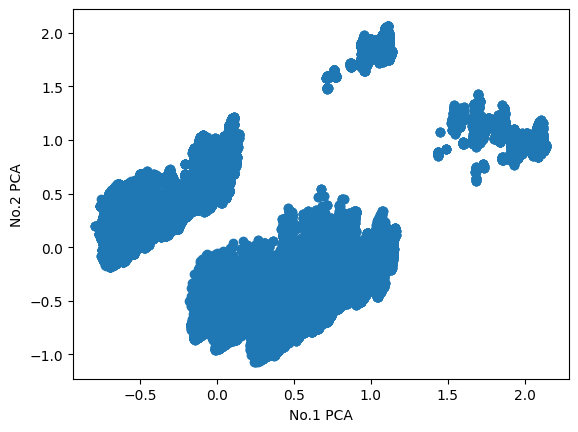

In [211]:
#Apply PCA to extract the most important features
from sklearn.decomposition import PCA
features_dict_copy = minMax_normalized
pca_y = minMax_normalized['Total Score extended']
pca_X = minMax_normalized.drop(['Total Score extended'], axis=1)
pca = PCA()
pca.fit(minMax_scalled)
v_ratio = pca.explained_variance_ratio_
num_com = len(v_ratio[v_ratio > 0.01])
tranform_pca = pca.transform(minMax_scalled)[:, :num_com]

# Visualize the data
plt.scatter(tranform_pca[:, 0], tranform_pca[:, 1])
plt.xlabel('No.1 PCA')
plt.ylabel('No.2 PCA')
plt.show()

In [212]:
#Now taking 10 top most features
pd_comp_dt = pd.DataFrame(pca.components_)
sort_features = pd_comp_dt.abs().max(axis=0).sort_values(ascending=False)
feature_map = dict(zip(range(len(pca_X.columns)), pca_X.columns))
mostly_used_features = [(feature_map[i], score) for i, score in enumerate(sort_features[:-1])]
mostly_used_features = sorted(mostly_used_features, key=lambda x: x[1], reverse=True)
for i, (feature, score) in enumerate(mostly_used_features):
    print(f"{i+1}. {feature}: {score:.3f}")

1. Recording timestamp: 0.952
2. Computer timestamp: 0.952
3. Recording duration: 0.950
4. Recording resolution height: 0.938
5. Recording resolution width: 0.930
6. Recording monitor latency: 0.928
7. Eyetracker timestamp: 0.907
8. Gaze point X: 0.881
9. Gaze point Y: 0.819
10. Gaze point left X: 0.801
11. Gaze point left Y: 0.739
12. Gaze point right X: 0.735
13. Gaze point right Y: 0.702
14. Gaze direction left X: 0.698
15. Gaze direction left Y: 0.696
16. Gaze direction left Z: 0.693
17. Gaze direction right X: 0.692
18. Gaze direction right Y: 0.687
19. Gaze direction right Z: 0.687
20. Pupil diameter left: 0.678
21. Pupil diameter right: 0.669
22. Eye position left X (DACSmm): 0.659
23. Eye position left Y (DACSmm): 0.653
24. Eye position left Z (DACSmm): 0.650
25. Eye position right X (DACSmm): 0.634
26. Eye position right Y (DACSmm): 0.595
27. Eye position right Z (DACSmm): 0.593
28. Gaze point left X (DACSmm): 0.574
29. Gaze point left Y (DACSmm): 0.567
30. Gaze point right X 

In [222]:
imp_columns = ['Recording duration', 'Pupil diameter left', 'Pupil diameter right', 'Gaze event duration', 'EyesNotFound','Fixation','Saccade','Unclassified','Gaze event duration', 'Gaze point X', 'Gaze point Y','Gaze point left X','Gaze point left Y','Gaze point right X','Gaze point right Y','Gaze direction left X','Gaze direction left Y','Gaze direction left Z','Gaze direction right X','Gaze direction right Y','Gaze direction right Z','Total Score extended','Participant nr', 'Trial']
df_copy = df.drop(columns=[col for col in df.columns if col not in imp_columns])

Here you can see successfullt extracted the top features by using PCA

In [223]:
group_result = df_copy.groupby(['Participant nr', 'Trial']).apply(group_func).reset_index(drop=True)
group_result

,Participant nr,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Gaze direction right Z,Pupil diameter left,Pupil diameter right,Gaze event duration,Trial,Total Score extended,EyesNotFound,Fixation,Saccade,Unclassified
0,2.0,106276.0,954.0,276.0,922.0,400.0,900.0,257.0,0.05370,0.04581,...,-0.99693,2.92,2.77,17.0,0.0,133.0,0.0,0.0,0.0,0.0
1,2.0,14124.0,904.0,318.0,819.0,30.0,946.0,277.0,-0.34373,-0.14628,...,-0.99971,2.47,2.49,150.0,1.0,133.0,0.0,1.0,0.0,0.0
2,2.0,15290.0,971.0,356.0,858.0,383.0,1015.0,401.0,0.05082,0.07341,...,-0.99669,3.16,2.97,908.0,2.0,133.0,0.0,1.0,0.0,0.0
3,2.0,228445.0,903.0,125.0,889.0,186.0,968.0,185.0,0.05497,0.08385,...,-0.99966,3.14,2.72,17.0,4.0,133.0,0.0,0.0,0.0,0.0
4,4.0,70463.0,966.0,605.0,828.0,606.0,1107.0,418.0,0.10455,0.07235,...,-0.99919,3.10,2.54,17.0,5.0,114.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,56.0,63928.0,969.0,634.0,494.0,665.0,1083.0,457.0,0.00027,0.21255,...,-0.99342,3.07,3.18,17.0,2.0,94.0,0.0,0.0,0.0,0.0
92,58.0,64958.0,939.0,361.0,945.0,370.0,935.0,375.0,0.02756,0.08537,...,-0.99980,3.71,3.54,17.0,0.0,131.0,0.0,1.0,0.0,0.0
93,58.0,63857.0,925.0,305.0,926.0,274.0,916.0,303.0,0.11283,-0.05360,...,-0.99677,3.75,3.66,17.0,2.0,131.0,0.0,1.0,0.0,0.0
94,60.0,66391.0,928.0,367.0,673.0,340.0,1171.0,340.0,-0.32150,-0.18677,...,-0.91209,3.26,3.04,17.0,0.0,123.0,0.0,1.0,0.0,0.0


In [224]:
participant_sum = group_result.groupby('Participant nr').size().reset_index(name='Sum')
print(participant_sum)

    Participant nr  Sum
0              2.0    4
1              4.0    4
2              6.0    4
3              8.0    4
4             10.0    4
5             12.0    4
6             14.0    4
7             16.0    4
8             18.0    4
9             20.0    4
10            22.0    4
11            24.0    4
12            26.0    3
13            28.0    4
14            30.0    4
15            32.0    3
16            34.0    4
17            36.0    4
18            38.0    4
19            40.0    2
20            42.0    2
21            44.0    2
22            46.0    2
23            48.0    2
24            50.0    2
25            52.0    2
26            54.0    2
27            56.0    2
28            58.0    2
29            60.0    2


In [231]:
group_result = group_result.sort_values('Trial')
group_result
df_copy = group_result

In [232]:
print("All Null Values:",df_copy.isnull().sum())

All Null Values: 0
Participant nr            0
Recording duration        0
Gaze point X              0
Gaze point Y              0
Gaze point left X         0
Gaze point left Y         0
Gaze point right X        0
Gaze point right Y        0
Gaze direction left X     0
Gaze direction left Y     0
Gaze direction left Z     0
Gaze direction right X    0
Gaze direction right Y    0
Gaze direction right Z    0
Pupil diameter left       0
Pupil diameter right      0
Gaze event duration       0
Trial                     0
Total Score extended      0
EyesNotFound              0
Fixation                  0
Saccade                   0
Unclassified              0
dtype: int64


In [233]:
# Create the scaler object
selectedColsScaler = MinMaxScaler()

# Fit and transform the data
selectedCols_scaled = selectedColsScaler.fit_transform(df_copy)

# Convert the scaled data back to a DataFrame
selectedCols_normalized = pd.DataFrame(selectedCols_scaled, columns=df_copy.columns)
selectedCols_normalized

,Participant nr,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Gaze direction right Z,Pupil diameter left,Pupil diameter right,Gaze event duration,Trial,Total Score extended,EyesNotFound,Fixation,Saccade,Unclassified
0,0.000000,0.429972,0.538827,0.323680,0.508900,0.462783,0.487024,0.365745,0.615052,0.400785,...,0.018689,0.227160,0.183824,0.002232,0.0000,0.795918,0.0,0.0,0.0,0.0
1,0.862069,0.233290,0.494453,0.393526,0.475728,0.438511,0.570069,0.471900,0.526856,0.116490,...,0.345386,0.461728,0.463235,0.002232,0.0000,0.224490,0.0,1.0,0.0,0.0
2,0.827586,0.241344,0.437401,0.752981,0.407767,0.762136,0.541522,0.394291,0.482494,0.378350,...,0.000183,0.422222,0.362745,0.002232,0.0000,0.387755,0.0,1.0,0.0,0.0
3,0.793103,0.224075,0.547544,0.349233,0.481392,0.496764,0.599481,0.549509,0.476006,0.363123,...,0.033897,0.217284,0.193627,1.000000,0.0000,0.714286,0.0,1.0,0.0,0.0
4,0.965517,0.237186,0.526941,0.396082,0.527508,0.438511,0.517301,0.471008,0.578735,0.449442,...,0.001160,0.422222,0.372549,0.002232,0.0000,0.755102,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.068966,0.302840,0.645800,0.155877,0.539644,0.563107,0.750000,0.614630,0.578207,0.350553,...,0.006841,0.380247,0.470588,0.002232,0.7500,0.551020,0.0,1.0,0.0,0.0
92,0.103448,0.239981,0.617274,0.493186,0.567152,0.528317,0.429066,0.675290,0.192634,0.301010,...,0.673365,0.516049,0.502451,0.002232,0.8125,0.448980,0.0,1.0,0.0,0.0
93,0.103448,0.231909,0.302694,0.160988,0.558252,0.201456,0.598616,0.469224,0.934534,0.129712,...,0.084041,0.553086,0.512255,0.002232,0.8750,0.448980,0.0,1.0,0.0,0.0
94,0.103448,0.240560,0.324089,0.065588,0.283172,0.550971,0.334775,0.536128,0.292681,0.310136,...,0.496916,0.479012,0.475490,0.002232,0.9375,0.448980,0.0,1.0,0.0,0.0


In [234]:
X = selectedCols_normalized.drop(['Total Score extended','Participant nr'], axis=1)
y = selectedCols_normalized['Total Score extended']
groups = selectedCols_normalized['Participant nr']  # Specify the group variable

group_shuffle_split = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Iterate over the group-wise splits
for train_index, test_index in group_shuffle_split.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Use X_train, y_train for training and X_test, y_test for testing
    # You can also print the shapes of the resulting arrays for verification
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)

Shape of X_train: (70, 21)
Shape of y_train: (70,)
Shape of X_test: (26, 21)
Shape of y_test: (26,)


In [235]:
randomForest = RandomForestRegressor(n_estimators=100, random_state=42)

groupFold = GroupKFold(n_splits=10)
scores = -cross_val_score(randomForest, X, y, cv=groupFold, groups=selectedCols_normalized['Participant nr'], scoring='neg_mean_squared_error', n_jobs=-1)
variance = np.var(y)
df_scores_D2 = pd.DataFrame({'R2 score': 1 - (scores/variance),'MSE':scores})
mean_score = scores.mean()
std_score = scores.std()

print("Mean Squared Error (MSE) on group k-fold cross-validation: {:.3f} +/- {:.3f}".format(mean_score, std_score))
print("Mean R2 on group k-fold cross-validation:{:.3f}".format(df_scores_D2['MSE'].mean()))
print("Variance",variance)
df_scores_D2

Mean Squared Error (MSE) on group k-fold cross-validation: 0.069 +/- 0.048
Mean R2 on group k-fold cross-validation:0.069
Variance 0.060799319727891134


,R2 score,MSE
0,0.639008,0.021948
1,0.084597,0.055656
2,-0.461087,0.088833
3,0.409732,0.035888
4,0.007980,0.060314
5,-1.471328,0.150255
6,-1.267005,0.137832
7,0.747342,0.015361
8,0.789054,0.012825
9,-0.901942,0.115637


In [236]:
randomForestReg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

randomForestReg.fit(X_train, y_train)
y_pred = randomForestReg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE) on test set: {:.3f}".format(mse))
print("R2 Score on test set: {:.3f}".format(r2))

Mean Squared Error (MSE) on test set: 0.098
R2 Score on test set: -0.541


In [250]:
def empathyPrediction(train_Set):
    testTrainSet = train_Set.copy()
    testTrainSet_Y = randomForestReg.predict(testTrainSet)
    testTrainSet['Total Score extended'] = testTrainSet_Y
    testTrainSet['Participant nr'] = 0
    y_pred_denormalized = selectedColsScaler.inverse_transform(testTrainSet)
    pred = pd.DataFrame(y_pred_denormalized)
    print("Empathy Score",pred.iloc[0][16])
    # Calculate feature importances
    importances = randomForestReg.feature_importances_

    # Convert the values to regular numbers
    importances = np.round(importances * 100, decimals=3)

    # Create a dictionary to map attribute names with importance values
    importances_dict = {attr: imp for attr, imp in zip(X.columns, importances)}

    return importances_dict
empathyPrediction(X_test)

Empathy Score 8.0


{'Recording duration': 6.585,
 'Gaze point X': 2.305,
 'Gaze point Y': 3.068,
 'Gaze point left X': 4.992,
 'Gaze point left Y': 9.318,
 'Gaze point right X': 3.107,
 'Gaze point right Y': 25.982,
 'Gaze direction left X': 1.068,
 'Gaze direction left Y': 7.585,
 'Gaze direction left Z': 10.1,
 'Gaze direction right X': 1.676,
 'Gaze direction right Y': 8.832,
 'Gaze direction right Z': 2.402,
 'Pupil diameter left': 7.284,
 'Pupil diameter right': 2.67,
 'Gaze event duration': 0.564,
 'Trial': 1.812,
 'EyesNotFound': 0.0,
 'Fixation': 0.651,
 'Saccade': 0.0,
 'Unclassified': 0.0}

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_r2_scores(df1, df2):
    fig, ax = plt.subplots()
    df1.plot(y='R2 score', ax=ax, label='D3 R2 Score', kind='line')
    df2.plot(y='R2 score', ax=ax, label='D2 R2 Score', kind='line')
    ax.set_title('R2 Score for Participants in D3 and D2')
    ax.set_xlabel('Fold')
    ax.set_ylabel('R2 Score')
    ax.legend()
    plt.show()

def plot_mse_scores(df1, df2):
    fig, ax = plt.subplots()
    df1.plot(y='MSE', ax=ax, label='D3 MSE', kind='line', color='red')
    df2.plot(y='MSE', ax=ax, label='D2 MSE', kind='line', color='green')
    ax.set_title('MSE for Participants in D3 and D2')
    ax.set_xlabel('Fold')
    ax.set_ylabel('MSE')
    ax.legend()
    plt.show()

# Assuming 'relation_1' and 'df_scores_D2' are your dataframes
plot_r2_scores(relation_1, df_scores_D2)
plot_mse_scores(relation_1, df_scores_D2)